<a href="https://colab.research.google.com/github/misbahsy/APMonitor-do/blob/master/DynamicData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dynamic Data Introduction

Data manipulation is important for dynamic optimization in order to set up simulations that utilize time-varying information. Several aspects of dynamic optimization involve the import, validation, filtering, manipulation, and display of large data sets. Select one of the following tutorials below on using MATLAB or Python to import, manipulate, and export data sets.

In [0]:
#@title
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/E56egH10RJA" frameborder="0" allowfullscreen></iframe>

<div class='vspace'></div>
<iframe width="560" height="315" src="https://www.youtube.com/embed/Tq6rCWPdXoQ" frameborder="0" allowfullscreen></iframe>


##Real Data Challenges
Real-data sources have a number of issues that can make simulation challenging. Measurements are used as inputs to a model, for parameter estimation, or in empirical model regression. Bad measurements can greatly affect the resulting model predictions, especially if strategies are not employed to minimize the effect of bad data.

A first step in data validation is gross error detection or when the data is clearly bad based on statistics or heuristics. Methods to automatically detect bad data include upper and lower validity limits and change validity limits. An example of a lower validity limit may be a requirement for positive (>0) values from a flow meter. Also, flow meters may not be able to detect flows above a certain limit, leading to an upper limit as well. An example of a change validity limit may be to detect sudden jumps in a measurement that are not realistic. For example, a gas chromatograph may suddenly report a jump in a gas concentration. If the gas chromatograph is measuring the concentration of a large gas phase polyethylene reactor, it is unrealistic for that concentration to change more than a certain rate. A change validity limit is able to catch these sudden shifts with gross error detection.


In [0]:
#@title
%%html
</p>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/bad_data.png' alt='' title='' /></div>
<p class='vspace'><strong>Figure 1.</strong> Example of (1) outlier, (2) drift, and (3) noise<sup><a class='urllink' href='https://dx.doi.org/10.1016/j.compchemeng.2014.04.013' rel='nofollow'>1</a></sup>.
</p>

Other examples of real-data issues include outliers (infrequent data points that are temporarily outside of an otherwise consistent trend in the data), noise (random variations in the data due to resolution or variations in the measurement or transmission of the data), and drift (inaccurate and gradual increase or decrease of the measurement value that does not represent the true values). Data may also be infrequent (such as measurements that occur every few hours or not at regular intervals), intermittent (such as from unreliable measurements that report good values for only certain periods of time), or time delayed (measurements that are reported after a waiting period). Synchronization of real data to process models can be challenging for all of these reasons.

Some estimators and controllers are designed with ideal measurements in simulation but then fail to perform in practice due to the issues with real measurements. It is important to use methods that perform well in a variety of situations and can either reject or minimize the effect of bad data.

In [0]:
#@title ##Exercise
%%html
<p><strong>Objective:</strong> Understand the effect of bad data on dynamic optimization algorithms including estimator and control performance. Create a MATLAB or Python script to simulate and display the results. <em>Estimated Time: 2 hours</em>
</p>
<p class='vspace'>The flowrate of mud and cuttings is especially important with managed pressure drilling (MPD) in order to detect gas influx or fluid losses. There are a range of measurement instruments for flow such as a <a class='urllink' href='https://en.wikipedia.org/wiki/Mass_flow_meter' rel='nofollow'>mass flow meter or Coriolis  flow meter (most accurate)</a> and a <a class='urllink' href='https://en.wikipedia.org/wiki/Flow_measurement#Paddle_wheel_meter' rel='nofollow'>paddle wheel (least accurate)</a>. This particular system has dynamics that are described by the following equation with C<sub>v</sub>=1, <em>u</em> is the valve opening, and <em>d</em> is a disturbance.
</p>
<div class='vspace'></div><pre> 0.1 d<em>F<sub>1</sub></em>/dt = -<em>F<sub>1</sub></em> + C<sub>v</sub> <em>u</em> + <em>d</em>
</pre><div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/drilling_flowrate.png' alt='' title='' /></div>
<p class='vspace'>Determine the effect of bad data (outliers, drift, and noise) on estimators such as such as moving horizon estimation. There is no need to design the estimators for this problem. The estimator scripts are below with sections that can be added to simulate the effect of bad data<sup>1</sup>. Only an outlier has been added to these code. The code should be modified to include other common phenomena such as measurement drift (gradual ramp away from the true value) and an increase in noise (random fluctuations). Comment on the effect of corrupted data on real-time estimation and why some methods are more effective at rejecting bad data.
</p>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/bad_data_exercise.zip' rel='nofollow'>Estimation with Outliers in MATLAB and Python</a></div>

<h4>Solution</h4>
<div><img src='http://apmonitor.com/do/uploads/Main/bad_data_estimation.png' alt='' title='' /></div>

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:            294
 Number of total equations: -          294
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 ----------------------------------------------
 Dynamic Estimation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  0.00000E+00  0.00000E+00
    1  0.00000E+00  0.00000E+00
 Successful solution
 
 ---------------------------------------------------
 S

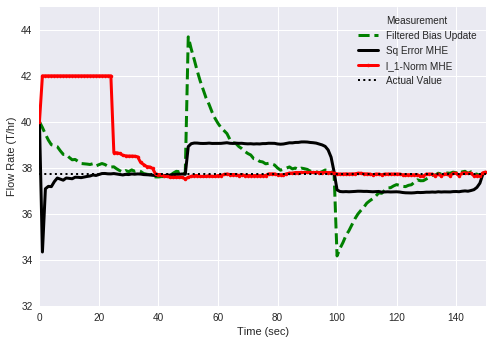

In [0]:
#@title Gekko solution

try:
    from pip import main as pipmain
except:
    from pip._internal import main as pipmain
pipmain(['install','gekko'])

from __future__ import division
from gekko import GEKKO
import numpy as np
import random

# intial parameters
n_iter = 150 # number of cycles
x = 37.727 # true value
# filtered bias update
alpha = 0.0951
# mhe tuning
horizon = 30

#%% Model

#Initialize model
m = GEKKO(remote=False)

# Solve options
rmt = True # Remote: True or False
# For rmt=True, specify server
m.server = 'https://byu.apmonitor.com'

#time array 
m.time = np.arange(50)

#Parameters
u = m.Param(value=42)
d = m.FV(value=0)
Cv = m.Param(value=1)
tau = m.Param(value=0.1)

#Variable
flow = m.CV(value=42)

#Equation 
m.Equation(tau * flow.dt() == -flow + Cv * u + d)

# Options
m.options.imode = 5
m.options.ev_type = 1 #start with l1 norm
m.options.coldstart = 1
m.options.solver = 1  # APOPT solver

d.status = 1
flow.fstatus = 1
flow.wmeas = 100
flow.wmodel = 0
#flow.dcost = 0

# Initialize L1 application
m.solve()

#%% Other Setup
# Create storage for results
xtrue = x * np.ones(n_iter+1)
z = x * np.ones(n_iter+1)
time = np.zeros(n_iter+1)
xb = np.empty(n_iter+1)
x1mhe = np.empty(n_iter+1)
x2mhe = np.empty(n_iter+1)

# initial estimator values
x0 = 40
xb[0] = x0
x1mhe[0] = x0
x2mhe[0] = x0

# outliers
for i in range(n_iter+1):
    z[i] = x + (random.random()-0.5)*2.0
z[50] = 100
z[100] = 0

#%% L1 Application

## Cycle through measurement sequentially
for k in range(1, n_iter+1):
    print( 'Cycle ' + str(k) + ' of ' + str(n_iter))
    time[k] = k

    # L1-norm MHE
    flow.meas = z[k] 
    m.solve()
    x1mhe[k] = flow.model

print("Finished L1")
#%% L2 application

#clear L1//
m.clear_data()
# Options for L2
m.options.ev_type = 2 #start with l1 norm
m.options.coldstart = 1 #reinitialize

flow.wmodel = 10

# Initialize L2 application
m.solve()

## Cycle through measurement sequentially
for k in range(1, n_iter+1):
    print ('Cycle ' + str(k) + ' of ' + str(n_iter))
    time[k] = k

    # L2-norm MHE
    flow.meas = z[k] 
    m.solve()
    x2mhe[k] = flow.model

#%% Filtered bias update

## Cycle through measurement sequentially
for k in range(1, n_iter+1):
    print ('Cycle ' + str(k) + ' of ' + str(n_iter))
    time[k] = k

    # filtered bias update
    xb[k] = alpha * z[k] + (1.0-alpha) * xb[k-1] 


#%% plot results
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(time,z,'kx',linewidth=2)
plt.plot(time,xb,'g--',linewidth=3)
plt.plot(time,x2mhe,'k-',linewidth=3)
plt.plot(time,x1mhe,'r.-',linewidth=3)
plt.plot(time,xtrue,'k:',linewidth=2)
plt.legend(['Measurement','Filtered Bias Update','Sq Error MHE','l_1-Norm MHE','Actual Value'])
plt.xlabel('Time (sec)')
plt.ylabel('Flow Rate (T/hr)')
plt.axis([0, time[n_iter], 32, 45])
plt.show()
